<a href="https://colab.research.google.com/github/cbbarnes/Computer-Vision-Final-Project/blob/master/ComVis_FinalProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Final Project

### Ships in Satellite Images

In [0]:
import json, sys, random
import numpy as np

#import theano
#theano.config.optimizer="None"

#import os
#os.environ['KERAS_BACKEND'] = 'theano'

import keras

from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
import keras.callbacks

from PIL import Image, ImageDraw 

from matplotlib import pyplot as plt

import pandas as pd

from keras.models import load_model
import coremltools
import argparse
import pickle



Using TensorFlow backend.
/Users/Chelsea/anaconda3/envs/tensorflow-sessions/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Chelsea/anaconda3/envs/tensorflow-sessions/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Chelsea/anaconda3/envs/tensorflow-sessions/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

In [0]:
# download dataset from json object
f = open(r'shipsnet.json')
dataset = json.load(f)
f.close()

In [0]:
input_data = np.array(dataset['data']).astype('uint8')
output_data = np.array(dataset['labels']).astype('uint8')

In [0]:
input_data.shape

(4000, 19200)

In [0]:
n_spectrum = 3 # color chanel (RGB)
weight = 80
height = 80
X = input_data.reshape([-1, n_spectrum, weight, height])
X[0].shape

(3, 80, 80)

In [0]:
# get one chanel
pic = X[0]

red_spectrum = pic[0]
green_spectrum = pic[1]
blue_spectum = pic[2]

#### Look at at different spectral bands of an image

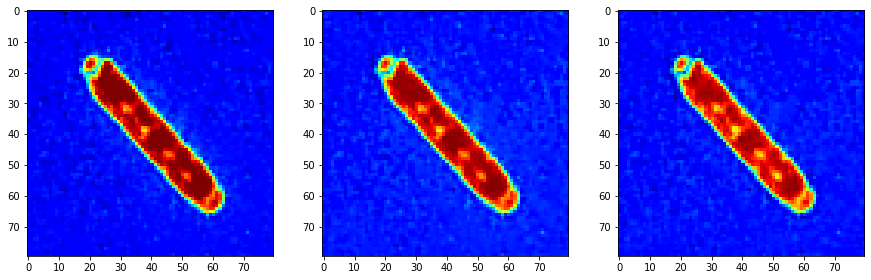

In [0]:
plt.figure(2, figsize = (5*3, 5*1))
plt.set_cmap('jet')

# show each channel
plt.subplot(1, 3, 1)
plt.imshow(red_spectrum)

plt.subplot(1, 3, 2)
plt.imshow(green_spectrum)

plt.subplot(1, 3, 3)
plt.imshow(blue_spectum)
    
plt.show()

In [0]:
output_data.shape

(4000,)

In [0]:
np.bincount(output_data)

array([3000, 1000])

In [0]:
# output encoding
y = np_utils.to_categorical(output_data, 2)

In [0]:
# shuffle all indexes
indexes = np.arange(2800)
np.random.shuffle(indexes)

In [0]:
X_train = X[indexes].transpose([0,2,3,1])
y_train = y[indexes]

In [0]:
# normalization
X_train = X_train / 255

In [0]:
np.random.seed(42)

#### Model Design

In [0]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model.add(Dropout(0.25))

model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [0]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy'])



In [0]:
# training
model.fit(
    X_train, 
    y_train,
    batch_size=20,
    epochs=10,
    validation_split=0.2,
    shuffle=True)

Train on 2240 samples, validate on 560 samples
Epoch 1/10
2240/2240 [==============================] - 17s 7ms/step - loss: 0.0773 - acc: 0.9746 - val_loss: 0.0426 - val_acc: 0.9893
Epoch 2/10
2240/2240 [==============================] - 17s 7ms/step - loss: 0.0529 - acc: 0.9826 - val_loss: 0.0411 - val_acc: 0.9911
Epoch 3/10
2240/2240 [==============================] - 17s 7ms/step - loss: 0.0390 - acc: 0.9906 - val_loss: 0.0386 - val_acc: 0.9893
Epoch 4/10
2240/2240 [==============================] - 17s 8ms/step - loss: 0.0373 - acc: 0.9875 - val_loss: 0.0323 - val_acc: 0.9946
Epoch 5/10
2240/2240 [==============================] - 17s 7ms/step - loss: 0.0275 - acc: 0.9902 - val_loss: 0.0281 - val_acc: 0.9946
Epoch 6/10
2240/2240 [==============================] - 17s 7ms/step - loss: 0.0269 - acc: 0.9933 - val_loss: 0.0353 - val_acc: 0.9929
Epoch 7/10
2240/2240 [==============================] - 17s 8ms/step - loss: 0.0179 - acc: 0.9929 - val_loss: 0.0307 - val_acc: 0.9929
Epoch 8/

In [0]:
#save the model to convert to CoreML
model.save('cnn_ships.h5')

#### Convert Keras model to CoreML

In [0]:
#pip install coremltools

In [0]:
output_labels = ['No Ship', 'Ship']
# Use coremltools to convert .h5 keras model to CoreML
coreml_ships = coremltools.converters.keras.convert(
    'cnn_ships.h5', input_names=['image'], output_names=['output'], 
    class_labels=output_labels, image_input_names='image', image_scale=1/255.0)

0 : conv2d_3_input, <keras.engine.input_layer.InputLayer object at 0x1a56881eb8>
1 : conv2d_3, <keras.layers.convolutional.Conv2D object at 0x1a56881e80>
2 : conv2d_3__activation__, <keras.layers.core.Activation object at 0x1a58906860>
3 : max_pooling2d_3, <keras.layers.pooling.MaxPooling2D object at 0x1a5688e080>
4 : conv2d_4, <keras.layers.convolutional.Conv2D object at 0x1a5688e240>
5 : conv2d_4__activation__, <keras.layers.core.Activation object at 0x1aa8e384a8>
6 : max_pooling2d_4, <keras.layers.pooling.MaxPooling2D object at 0x1a568a2b70>
7 : conv2d_5, <keras.layers.convolutional.Conv2D object at 0x1a56f76ba8>
8 : conv2d_5__activation__, <keras.layers.core.Activation object at 0x1aa8322cc0>
9 : max_pooling2d_5, <keras.layers.pooling.MaxPooling2D object at 0x1aa6a66cf8>
10 : conv2d_6, <keras.layers.convolutional.Conv2D object at 0x1a5747eeb8>
11 : conv2d_6__activation__, <keras.layers.core.Activation object at 0x1aa8322c88>
12 : max_pooling2d_6, <keras.layers.pooling.MaxPooling2D 

In [0]:
print(coreml_ships)

input {
  name: "image"
  type {
    imageType {
      width: 80
      height: 80
      colorSpace: RGB
    }
  }
}
output {
  name: "output"
  type {
    dictionaryType {
      stringKeyType {
      }
    }
  }
}
output {
  name: "classLabel"
  type {
    stringType {
    }
  }
}
predictedFeatureName: "classLabel"
predictedProbabilitiesName: "output"
metadata {
  userDefined {
    key: "coremltoolsVersion"
    value: "3.3"
  }
}



In [0]:
coreml_ships.author = 'Chelsea Barnes'
coreml_ships.license = 'Barnes'
coreml_ships.short_description = 'Ships in satellite imagery recognition'
coreml_ships.input_description['image'] = 'Ship image'
coreml_ships.output_description['output'] = 'Probability of ship'
coreml_ships.output_description['classLabel'] = 'Label of Ship'

In [0]:
coreml_ships.save('ShipsClassifier.mlmodel')

### Import satellite image scene and identify ships in image

In [0]:
image = Image.open('lb_3.png')
pix = image.load()

In [0]:
n_spectrum = 3
width = image.size[0]
height = image.size[1]

In [0]:
# creat vector
picture_vector = []
for chanel in range(n_spectrum):
    for y in range(height):
        for x in range(width):
            picture_vector.append(pix[x, y][chanel])

In [0]:
picture_vector = np.array(picture_vector).astype('uint8')
picture_tensor = picture_vector.reshape([n_spectrum, height, width]).transpose(1, 2, 0)

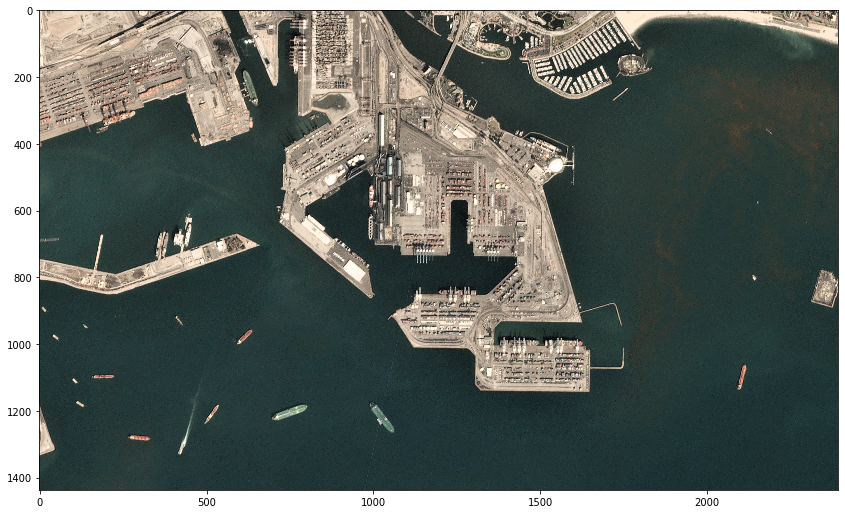

In [0]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3, 1, 1)
plt.imshow(picture_tensor)

plt.show()

In [0]:
picture_tensor = picture_tensor.transpose(2,0,1)

In [0]:
def cutting(x, y):
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = picture_tensor[0][y+i][x+j]
            area_study[1][i][j] = picture_tensor[1][y+i][x+j]
            area_study[2][i][j] = picture_tensor[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study.transpose([0,2,3,1])
    area_study = area_study / 255
    sys.stdout.write('\rX:{0} Y:{1}  '.format(x, y))
    return area_study

In [0]:
def not_near(x, y, s, coordinates):
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result

In [0]:
def show_ship(x, y, acc, thickness=5): 
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x-th] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x+th+80] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y-th][x+i] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+th+80][x+i] = -1

X:730 Y:120   [[0.09753466 0.90246534]]


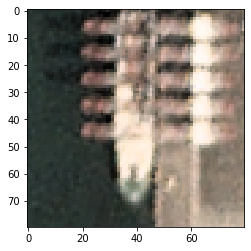

X:1720 Y:120  [[0.05139686 0.94860315]]


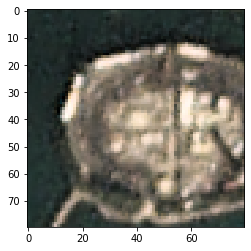

X:450 Y:340   [[0.06449459 0.9355054 ]]


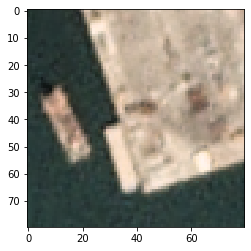

X:950 Y:490   [[0.05537574 0.94462425]]


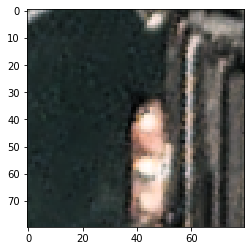

X:400 Y:590   [[0.06697898 0.933021  ]]


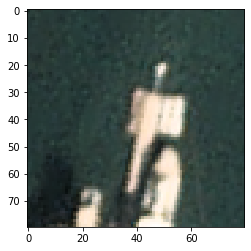

X:950 Y:600   [[0.06776801 0.93223196]]


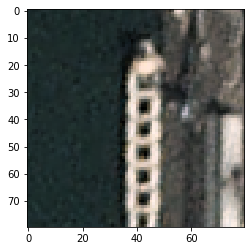

X:570 Y:650  [[0.09220241 0.9077976 ]]


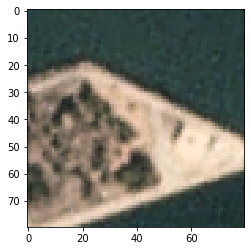

X:2100 Y:760  [[0.05598499 0.944015  ]]


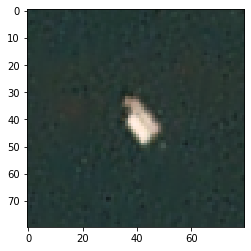

X:1690 Y:860  [[0.09787485 0.9021252 ]]


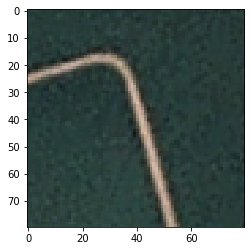

X:580 Y:930   [[0.01829781 0.9817022 ]]


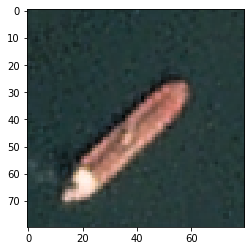

X:10 Y:940    [[0.04537437 0.9546256 ]]


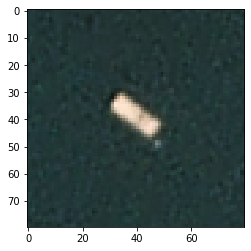

X:2070 Y:1030  [[0.01432844 0.9856716 ]]


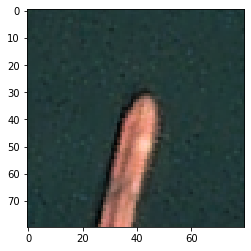

X:170 Y:1050   [[0.05758592 0.9424141 ]]


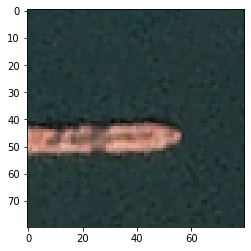

X:70 Y:1070    [[0.06396763 0.93603235]]


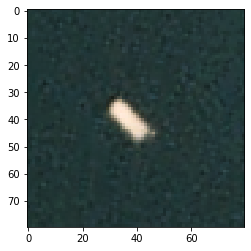

X:480 Y:1160   [[0.09648284 0.9035171 ]]


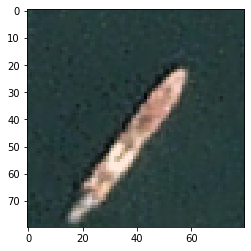

X:240 Y:1240   [[0.02079302 0.979207  ]]


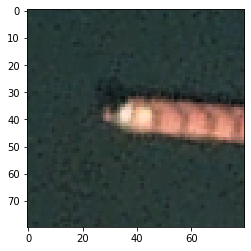

X:2310 Y:1350  

In [0]:
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1] > 0.90 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
            print(result)
            plt.imshow(area[0])
            plt.show()

In [0]:
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][1])

In [0]:
#picture_tensor = picture_tensor.transpose(2,0,1)
picture_tensor = picture_tensor.transpose(1,2,0)
picture_tensor.shape

(1437, 2393, 3)

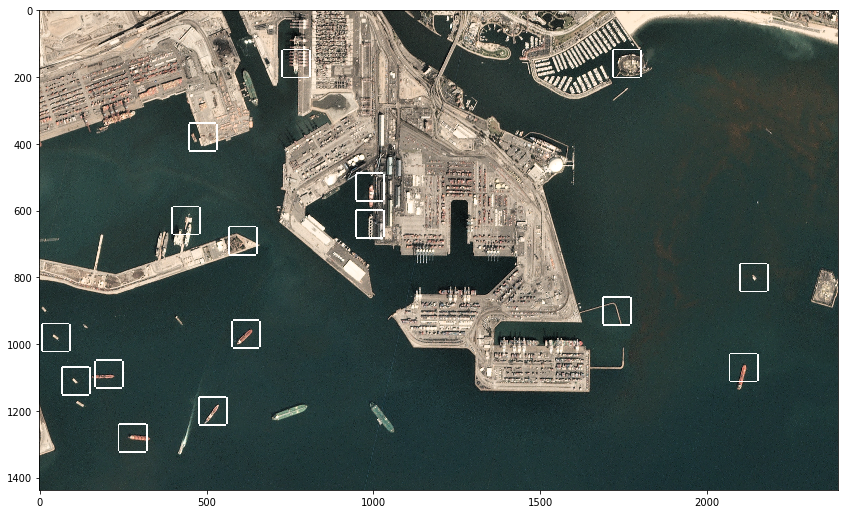

In [0]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor)

plt.show()